In [66]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm
from estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u
from scipy.integrate import nquad, quad
from mpmath import spherharm
from scipy.special import sph_harm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
def MdMdb(b, c, M):
    """ NFW mass and derivative within a cylinder or radius `b`

        :param b: Cylinder radius, in natural units
        :param c: NFW concentration
        :param M: NFW mass
        :return: mass within `b`, derivative of mass within `b` at `b`
    """
    delta_c = (200/3.)*c**3/(np.log(1+c) - c/(1+c)) 
    rho_s = rho_c*delta_c 
    r_s = (M/((4/3.)*np.pi*c**3*200*rho_c))**(1/3.) # NFW scale radius
    x = b/r_s 
    M = 4*np.pi*rho_s*r_s**3*(np.log(x/2.) + F(x))
    dMdb = 4*np.pi*rho_s*r_s**2*((1/x) + dFdx(x))

    return M

def dFdx(x):
    """ Helper function for NFW deflection, from astro-ph/0102341 eq. (49)
    """
    return (1-x**2*F(x))/(x*(x**2-1))

def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341 eq. (48)
    """
    if x > 1:
        return np.arctan(np.sqrt(x**2-1))/(np.sqrt(x**2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return np.arctanh(np.sqrt(1-x**2))/(np.sqrt(1-x**2))
    
def Ylm(l, m, theta, phi): 
    """
    Redefine spherical harmonics from scipy.special
    to match physics convention.
    
    Parameters
    ----------
    l : int, array_like
        Degree of the harmonic (int); ``l >= 0``.
    m : int, array_like
        Order of the harmonic (int); ``|m| <= l``.
    theta : array_like
        Polar (colatitudinal) coordinate; must be in ``[0, pi]``.
    phi : array_like
        Azimuthal (longitudinal) coordinate; must be in ``[0, 2*pi]``.
    
    Returns
    -------
    Ylm : complex float
       The harmonic Ylm sampled at ``theta`` and ``phi``.
    """
    if np.abs(m) > l:
        Ylm = 0
    else:
        Ylm = sph_harm(m, l, phi, theta) # Perform redefinition, scipy version
        # Ylm = spherharm(l, m, theta, phi) # mpmath version
    return Ylm


In [157]:
from scipy.special import lpn, legendre, jv

In [158]:
jv(1,2)

0.5767248077568736

In [167]:
def M(b):
    return MdMdb(b, 10,1e7*M_s)

def alm_NP(l, m):
    vtheta = 1
    Dl = 10*kpc
    pref = 4*GN*vtheta/Dl**2
    integ_re = nquad(lambda theta, phi: np.cos(phi)*np.sin(theta)/theta * M(theta*Dl) * np.real(Ylm(l, m, theta, phi)), [[0, np.pi], [0, 2*np.pi]])
    integ_im = nquad(lambda theta, phi: np.cos(phi)*np.sin(theta)/theta * M(theta*Dl) * np.imag(Ylm(l, m, theta, phi)), [[0, np.pi], [0, 2*np.pi]])
    return pref*integ_re[0] - 1.j*pref*integ_im[0]

def alm_NP(l, m):
    vtheta = 1*Kmps
    Dl = 10*kpc
    pref = GN*vtheta/Dl**2
    return pref*np.sqrt(4*np.pi*(2*l+1))*np.array(quad(lambda theta: M(theta*Dl)*jv(1, l*theta), 0, np.pi))[0]

def alm_NP(l, m):
    vtheta = 1*Kmps
    Dl = 10*kpc
    pref = GN*vtheta/Dl**2
    R0 = 5*kpc
    beta_l = R0/Dl
    return pref*np.sqrt(4*np.pi*(2*l+1))/l*np.exp(-l**2*beta_l**2/2)

In [171]:
ell_ary = np.logspace(0,np.log10(1000),1000)
alm_ary = [alm_NP(ell,1) for ell in ell_ary]

In [178]:
180/np.degrees(0.5)

6.283185307179586

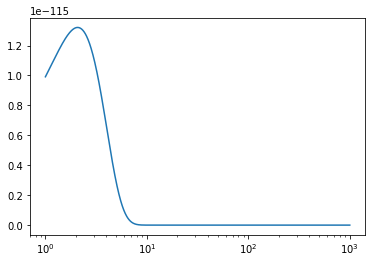

In [176]:
plt.plot(ell_ary, ell_ary*(ell_ary+1)*alm_ary)
plt.xscale("log")
# plt.yscale("log")